# Descripción del proyecto

**Autor:** Cristian Jeraldo, www.asgeominspa.com

**Fecha:** 13 de junio de 2024

**Descripción:** Este notebook contiene los pasos necesarios para desarrollar un análisis de precisión analítica, incluyendo la visualización de resultados y la aplicación de técnicas estadísticas de medición. El método hiperbólico está basado en lo desarrollado por Armando Simón.

---

# Importación de librerías

In [1]:
# Librerías visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías manipulación de datos
import numpy as np
import pandas as pd

C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Importación de datos

In [2]:
# Importación de datos
df = pd.read_csv('precisión_Cu.csv')

In [3]:
df.head(3)

,SAMPLE_ID,Inserto,Cu original,Cu duplicado
0,AAA-1001,1,1.24,1.17
1,AAA-1002,2,1.44,1.42
2,AAA-1003,3,1.60,1.60


In [4]:
df.shape

(284, 4)

# Scatterplot

In [5]:
# Ejes para scatterplot
x = df['Cu original']
y = df['Cu duplicado']

In [6]:
len(x)

284

In [7]:
# Editar tipo de control, analito y laboratorio 
control = 'duplicado fino (DP)' # analítico o preparación mecánica
analito = 'Cu (%)'
lab = 'Bureau Veritas Antofagasta, Chile'

In [8]:
# Tolerancia: DP = 0.1 (10%); DG = 0.2 (20%); MG = 0.3 (30%).
tol = 0.1
max_tol = 1 + tol
min_tol = 1 - tol
tol_porc = tol * 100

# Método tradicional

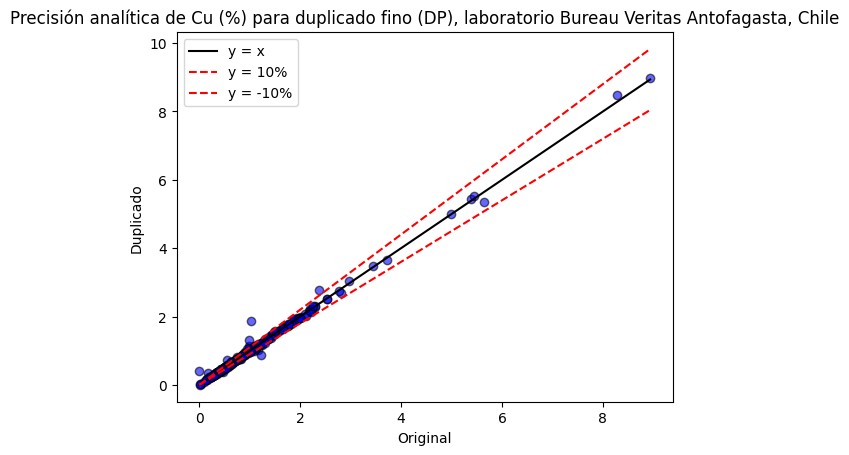

In [9]:
# Gráfico (scatterplot) control de precisión analítica
fig,ax = plt.subplots()

# Scatterplot original-duplicado
plt.scatter(x, y, c='blue', edgecolor='black', alpha=0.6)

# Línea y = x
x_vals = np.linspace(0, max(x), 2)
y_vals = x_vals
plt.plot(x_vals, y_vals, 'k-', label='y = x')

# Línea y = max_tol*x (+tol%)
y_10_more = max_tol * x_vals
plt.plot(x_vals, y_10_more, 'r--', label='y = {:.0f}%'.format(tol_porc))

# Línea y = (1 - tol)*x (-tol%)
y_10_less = min_tol * x_vals
plt.plot(x_vals, y_10_less, 'r--', label='y = -{:.0f}%'.format(tol_porc))

# Títulos
plt.xlabel('Original')
plt.ylabel('Duplicado')
ax.set_title("Precisión analítica de {} para {}, laboratorio {}".format(analito,control,lab))
plt.legend()

# Show plot
plt.show()

# Método hiperbólico

In [10]:
first_500_integers = list(range(501))

In [11]:
x_hip = (np.array(first_500_integers) * max(x)) / 500

In [12]:
# Cálculo de m^2, siendo m coeficiente en función y = m*x
# Error relativo aceptable para DP 10%; DG 20%; MG 30%
er = 0.1 # modificar según control de calidad
m = (2 + er) / (2 - 0.1)

***Definición***: El límite práctico de detección (PDL) en control de calidad para análisis químico es la concentración mínima de un analito que puede ser detectada con un nivel de confianza razonable, considerando las condiciones de medición y el ruido de fondo. El PDL es superior al límite de detección (LOD) teórico debido a factores prácticos como la variabilidad del instrumental, el procedimiento analítico y las interferencias en la muestra.

In [13]:
# Cálculo Límite Práctico de Detección
df['ER'] = 2 * abs(x - y) / (x + y) # Cálculo y generación de columna error relativo (ER)
df['prom'] = (x + y ) / 2 # Cálculo y generación de columna promedio original-duplicado

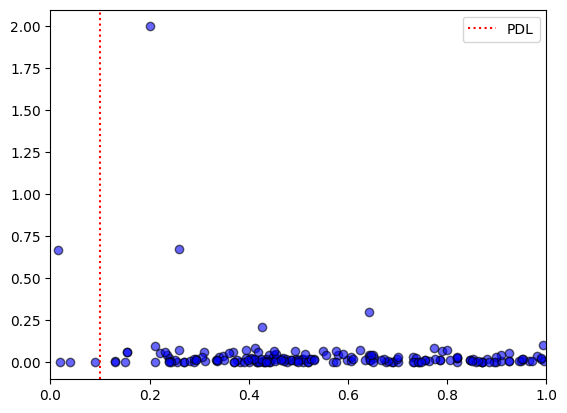

In [14]:
# Scatterplot promedio ley vs ER
plt.scatter(df['prom'], df['ER'], c='blue', edgecolor='black', alpha=0.6)
plt.xlim(0,1) # rango eje X

# Agregar línea que represente el PDL
plt.axvline(x=0.1, color='red', linestyle=':', label='PDL') # Editar el valor de x, el que corresponde a PDL
plt.legend(); 

***Factor***: dependiendo de la variabilidad del analito y la etapa de muestreo, los factores varían de la forma siguiente:

- Muestras gemelas o duplicados de campo: 10-20
- Duplicados gruesos: 5-10
- Duplicados de pulpa: 3-5

Utilizar valores cercanos a ***límite inferior*** de cada rango para elementos de baja variabilidad como Cu.<br>
Utilizar valores cercanos a ***límite superior*** de cada rango para elementos de alta variabilidad como Au.

In [15]:
# Cálculo de coeficiente b en función hiperbólica
factor = 3 # factor cobre EAA. Modificar según corresponda
pdl = 0.1
b = factor * pdl

In [16]:
# Cálculo de y según función hiperbólica
y_hip = np.sqrt(m**2 * x_hip**2 + b**2)

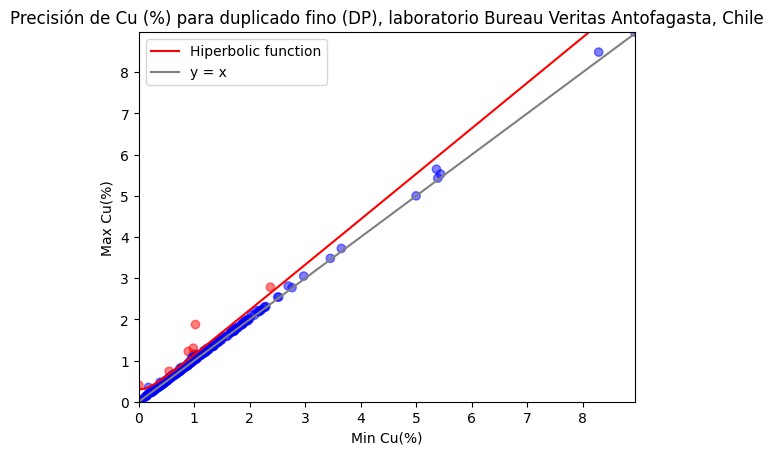

In [20]:
# Gráfico (scatterplot) control de precisión analítica
fig,ax = plt.subplots()

# Función hiperbólica m^2*x^2 + b^2
plt.plot(x_hip, y_hip, c='red', label='Hiperbolic function')

# Crear listas vacías
x_correct = []
y_correct = []

# Asegurar que x es el menor entre x e y
for i in range(len(x)):
    if x[i] > y[i]:
        x_correct.append(y[i])
        y_correct.append(x[i])
    else:
        x_correct.append(x[i])
        y_correct.append(y[i])
        
# Generar arrays desde las dos listas (array requerido para numpy)
x = np.array(x_correct)
y = np.array(y_correct)

# Interpolar los valores de la curva para los puntos x (datos originales analíticos) del scatter
y_curva_interpolada = np.sqrt(m**2 * x**2 + b**2)

# Determinar los colores de los puntos
colors = np.where(y > y_curva_interpolada, 'r', 'b')

# Scatterplot original-duplicado 
plt.scatter(x, y, c=colors, alpha=0.5)

# Línea y = x
x_vals = np.linspace(0, max(x), 2)
y_vals = x_vals
plt.plot(x_vals, y_vals, c='grey', label='y = x')

# Editar rango eje Y y X 
plt.ylim([0.0,max(y)])
plt.xlim([0.0,max(x)])

# Contar los puntos sobre la curva exponencial (puntos rojos)
num_puntos_sobre_hip = np.sum(colors == 'r')

# Títulos
plt.xlabel('Min Cu(%)') # Editar analito
plt.ylabel('Max Cu(%)') # Editar analito
ax.set_title("Precisión de {} para {}, laboratorio {}".format(analito,control,lab))
plt.legend()

# Show plot
plt.show()

# Cálculo porcentaje controles sobre Límite de Especificación

In [18]:
# Porcentaje de fallos
fallos = num_puntos_sobre_hip / len(x) * 100

In [19]:
print("El porcentaje de fallos de {} para {} en laboratorio {} es {:.2f}%".format(control,analito,lab,fallos))

El porcentaje de fallos de duplicado fino (DP) para Cu (%) en laboratorio Bureau Veritas Antofagasta, Chile es 2.46%


**Conclusión:**
- Porcentaje de fallos aceptable, dado que solo 2.46% de los pares yace fuera del límite de aceptación 10% de eror relativo.